In [95]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from IPython.display import display
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from PIL import Image
import random

In [11]:
for dirname, _, filenames in os.walk('data/cats_dogs_sample'):
    print(dirname)

data/cats_dogs_sample
data/cats_dogs_sample\test
data/cats_dogs_sample\test\cats
data/cats_dogs_sample\test\dogs
data/cats_dogs_sample\train
data/cats_dogs_sample\train\cats
data/cats_dogs_sample\train\dogs


### Data Prep

In [14]:
dataset = ImageFolder('data/cats_dogs_sample/train/')
dataset.classes

['cats', 'dogs']

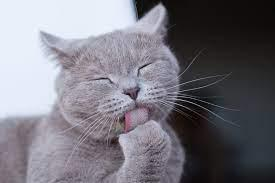

In [25]:
display(dataset[0][0])

In [26]:
len(dataset)

60

In [28]:
transform = transforms.Compose([transforms.Resize((255,255) ),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

In [29]:
train_dataset = ImageFolder('data/cats_dogs_sample/train/', transform = transform)

In [33]:
train_dataset[0][0].shape

torch.Size([3, 255, 255])

In [34]:
torch.concat((train_dataset[0][0],train_dataset[1][0]), dim = 1 ).shape

torch.Size([3, 510, 255])

In [36]:
torch_concatinated = torch.concat([data[0] for data in train_dataset], dim = 1)
torch_concatinated.shape

torch.Size([3, 15300, 255])

In [37]:
mean = torch.mean(torch_concatinated, dim = (1,2))
mean

tensor([0.5762, 0.5604, 0.4927])

In [38]:
std_dev =torch.std(torch_concatinated, dim = (1,2))
std_dev

tensor([0.3023, 0.2916, 0.3174])

In [39]:
additional_transform = transforms.Compose([
    transforms.Normalize(mean, std_dev)
])
train_dataset.transform.transforms.append(additional_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


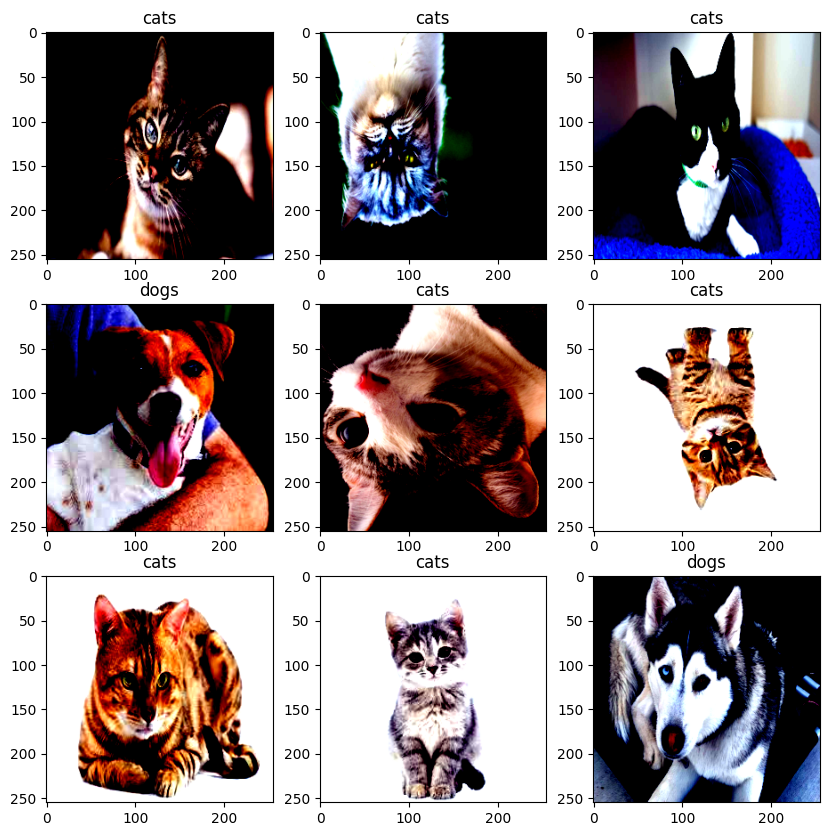

In [51]:
fig = plt.figure(figsize=(10, 10))
cols = 3
rows =3
for i in range(1,cols*rows+1):
    idx = torch.randint(len(train_dataset),size=(1,)).item()
    img, label = train_dataset[idx]
    class_name = train_dataset.classes[label]
    fig.add_subplot(rows, cols, i)
    plt.title(class_name)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [52]:
test_dataset = ImageFolder('data/cats_dogs_sample/test/', transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor()
    ,additional_transform
]))

In [53]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)

### Arch design phase

In [56]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(96),
            
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(256)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### setting up hyper parameters

In [62]:
model = AlexNet(2)

In [63]:
device = "cpu"
model.to(device=device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d

In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr =  0.0001)

### training

In [65]:
train_accuracies = []
test_accuracies = []
num_epochs = 4
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track train loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate train accuracy and loss
    train_accuracy = correct_train / total_train
    train_loss = train_loss / total_train
    
    train_accuracies.append(train_accuracy)
    # Evaluation (Test)
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track test loss and accuracy
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calculate test accuracy and loss
    test_accuracy = correct_test / total_test
    test_loss = test_loss / total_test
    
    test_accuracies.append(test_accuracy)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.4f}")

100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Epoch 1/4 - Train Loss: 0.7102 - Train Acc: 0.4333 - Test Loss: 0.6961 - Test Acc: 0.5000


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 2/4 - Train Loss: 0.6941 - Train Acc: 0.5500 - Test Loss: 0.6976 - Test Acc: 0.5000


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 3/4 - Train Loss: 0.6847 - Train Acc: 0.5667 - Test Loss: 0.6957 - Test Acc: 0.5000


100%|██████████| 15/15 [00:17<00:00,  1.13s/it]


Epoch 4/4 - Train Loss: 0.6992 - Train Acc: 0.5333 - Test Loss: 0.6923 - Test Acc: 0.4000


In [72]:
torch.save(model.state_dict(),"model/base_model_v1.pth")

### Prediction

In [73]:
loaded_model = AlexNet(2)
loaded_model.load_state_dict(torch.load("model/base_model_v1.pth"))

<All keys matched successfully>

In [75]:
additional_transform

Compose(
    Normalize(mean=tensor([0.5762, 0.5604, 0.4927]), std=tensor([0.3023, 0.2916, 0.3174]))
)

In [92]:
class ClassPredictor:
    def __init__(self,model,class_map) -> None:
        self.model = model
        self.class_map = class_map
    def preprocess(self,img_path):
        preprocess =transforms.Compose([
            transforms.Resize((255, 255)),
            transforms.ToTensor()
            ,transforms.Normalize(mean=[0.5762, 0.5604, 0.4927], std=[0.3023, 0.2916, 0.3174])
        ])
        image = Image.open(img_path).convert("RGB")
        image = preprocess(image)
        image = image.unsqueeze(0)
        return image
    def model_pred(self,img_tensor):
        self.model.eval()
        with torch.no_grad():
            output = self.model(img_tensor)
        _, pred_class = output.max(1)
        return self.class_map[pred_class.item()]
    def predict(self,img_path):
        img_tensor = self.preprocess(img_path=img_path)
        return self.model_pred(img_tensor=img_tensor)

In [93]:
class_map = {
    0:"cat",
    1:"dog"
}
pred_obj = ClassPredictor(model=model,class_map=class_map)

In [94]:
img_path = 'data/cats_dogs_sample/test/dogs/dog_344.jpg'
pred_obj.predict(img_path)

'dog'

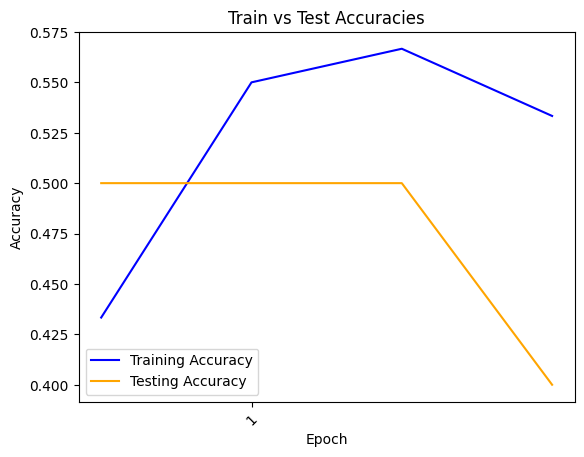

In [70]:
sns.lineplot(x = range(4), y = train_accuracies, color = "blue", label = "Training Accuracy")
sns.lineplot(x = range(4), y = test_accuracies, color = "orange", label = "Testing Accuracy")
plt.title("Train vs Test Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1,4,10), rotation = 45)
plt.yticks(label = range(1,4,15))
plt.legend()
plt.show()

In [71]:
transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor()
    ,additional_transform
])

ModuleNotFoundError: No module named 'sklearn'

In [74]:
additional_transform

Compose(
    Normalize(mean=tensor([0.5762, 0.5604, 0.4927]), std=tensor([0.3023, 0.2916, 0.3174]))
)